In [1]:
# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import math
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ',os.getcwd())

# Vis Libs..
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Libs..
import re
from gensim import corpora, models
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import GridSearchCV


CWD is  d:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\Thesis-Ecommerce-Price-Prediction\3. Modelling


# 6. Final Data Preparation

In [2]:
file = open(r'D:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\Thesis-Ecommerce-Price-Prediction\2. Processing\storage\train_bow_name', 'rb')
train_bow_name = pickle.load(file)
file.close()

file = open(r'D:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\Thesis-Ecommerce-Price-Prediction\2. Processing\storage\train_bow_desc', 'rb')
train_bow_desc = pickle.load(file)
file.close()

file = open(r'D:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\Thesis-Ecommerce-Price-Prediction\2. Processing\storage\train_brand', 'rb')
train_brand = pickle.load(file)
file.close()

file = open(r'D:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\Thesis-Ecommerce-Price-Prediction\2. Processing\storage\train_category', 'rb')
train_category = pickle.load(file)
file.close()

file = open(r'D:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\Thesis-Ecommerce-Price-Prediction\2. Processing\storage\train_dummies', 'rb')
train_dummies = pickle.load(file)
file.close()

file = open(r'D:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\Thesis-Ecommerce-Price-Prediction\2. Processing\storage\y_train', 'rb')
y_train = pickle.load(file)
file.close()


In [3]:
file = open(r"D:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\Thesis-Ecommerce-Price-Prediction\2. Processing\storage\test_bow_name", "rb")
test_bow_name = pickle.load(file)
file.close()

file = open(r"D:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\Thesis-Ecommerce-Price-Prediction\2. Processing\storage\test_bow_desc", "rb") 
test_bow_desc = pickle.load(file)
file.close()

file = open(r"D:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\Thesis-Ecommerce-Price-Prediction\2. Processing\storage\test_brand", "rb")
test_brand = pickle.load(file)
file.close()

file = open(r"D:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\Thesis-Ecommerce-Price-Prediction\2. Processing\storage\test_category", "rb")
test_category = pickle.load(file)
file.close()

file = open(r"D:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\Thesis-Ecommerce-Price-Prediction\2. Processing\storage\test_dummies", "rb")
test_dummies = pickle.load(file)
file.close()

file = open(r"D:\Downloads\NEU\NAM 3 KI 2\Đề án DSEB\Thesis-Ecommerce-Price-Prediction\2. Processing\storage\y_test", "rb")
y_test = pickle.load(file)
file.close()


In [4]:
 # ref - https://stackoverflow.com/questions/50250432/python-lightgbm-text-classicication-with-tfidf
'''
This code concatenates all the features that we generated 
using scipy.sparse.hstack function and converts datatype 
into 'float32' format so as to feed into Machine Learning models
'''

X_train = scipy.sparse.hstack((train_bow_name,train_bow_desc,train_brand,train_category,train_dummies)).tocsr().astype('float32')
X_test = scipy.sparse.hstack((test_bow_name,test_bow_desc,test_brand,test_category,test_dummies)).tocsr().astype('float32')

print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (1111901, 137271)
X_test shape :  (370634, 137271)
y_train shape :  (1111901,)
y_test shape :  (370634,)


In [5]:

file = open('final_processing/X_train', 'wb')
pickle.dump(X_train, file)
file.close()

file = open('final_processing/y_train', 'wb')
pickle.dump(y_train, file)
file.close()

file = open('final_processing/X_test', 'wb')
pickle.dump(X_test, file)
file.close()

file = open('final_processing/y_test', 'wb')
pickle.dump(y_test, file)
file.close()

# 7. Evaluation Metrics
This code creates the RMSLE scorer function
which would be used as Evalation metric for ML models

In [6]:
# def rmsle_score(y, y_pred):
#     assert len(y) == len(y_pred)
#     to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i, pred in enumerate(y_pred)]
#     return (sum(to_sum) * (1.0/len(y))) ** 0.5


def rmsle_score(y, y_pred):
    y = y.reset_index(drop=True)
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1))** 2.0
               for i in range(len(y_pred))]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [7]:
def rmsle_lgb(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2)), False

In [8]:
# Function for RMSE - Root Mean Square Error
def rmse_score(y, y_pred):
    return math.sqrt(mean_squared_error(y, y_pred))

# 8. Baseline Ridge Model

## 8.1 Using Existing Hyperparameters

In [9]:
ridge_model = Ridge(solver = "lsqr", fit_intercept=False)
ridge_model.fit(X_train, y_train)

Ridge(fit_intercept=False, solver='lsqr')

In [10]:
preds = np.expm1(ridge_model.predict(X_test))
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(ridge_model.predict(X_train))))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test), preds),'\n')
print('Train RMSE = ',rmse_score(np.expm1(y_train), np.expm1(ridge_model.predict(X_train))))
print('Test RMSE = ',rmse_score(np.expm1(y_test), preds))

Train RMSLE =  0.42907000546469
Test RMSLE =  0.4775898986044 

Train RMSE =  28.100424935698896
Test RMSE =  35.1535096034365


Summary - Train RMSLE of 0.429 and Test RMSLE of 0.477 suggests model is slightly overfitting, We can perform hyperparameter tuning to correct this

## 8.2 Tune Hyperparameters
Code for Hyperparameter Search using GridSearchCV function

In [11]:
parameters = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    "fit_intercept": [False],
    "solver": ["lsqr"]
}

gs_ridge = GridSearchCV(estimator=Ridge(), param_grid=parameters, cv=3, scoring = 'neg_mean_squared_error', verbose=1, return_train_score = True, n_jobs = -2)
gs_ridge.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-2,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000],
                         'fit_intercept': [False], 'solver': ['lsqr']},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

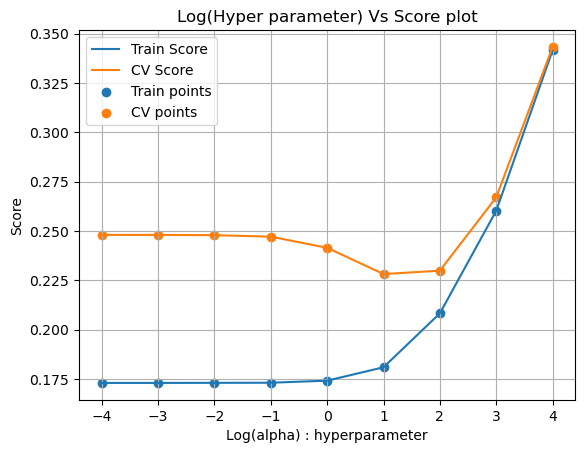

Best Estimator  Ridge(alpha=10, fit_intercept=False, solver='lsqr')


In [12]:
results = pd.DataFrame.from_dict(gs_ridge.cv_results_)
results = results.sort_values(['param_alpha'])

train_score = results['mean_train_score']*-1 # *-1 to convert from negative MSE to RMSE
cv_score = results['mean_test_score']*-1
hyp = results['param_alpha']

plt.plot(np.log10(list(hyp.values)), train_score, label='Train Score')
plt.plot(np.log10(list(hyp.values)), cv_score, label='CV Score')

plt.scatter(np.log10(list(hyp.values)), train_score, label='Train points')
plt.scatter(np.log10(list(hyp.values)), cv_score, label='CV points')

plt.legend()
plt.xlabel("Log(alpha) : hyperparameter")
plt.ylabel("Score")
plt.title("Log(Hyper parameter) Vs Score plot")
plt.grid()
plt.show()

print("Best Estimator ", gs_ridge.best_estimator_)

Plot Summary - As we can see from the Hyperparameter(alpha) vs score graph, alpha = 10 gave the lowest Cross Validation score, Hence we can use this value for our model, Re-training model using alpha = 10

## 8.3 Re-train Model with Best Hyperparameters

In [13]:
ridge_model = Ridge(alpha = 10, solver = "lsqr", fit_intercept=False)
ridge_model.fit(X_train, y_train)

Ridge(alpha=10, fit_intercept=False, solver='lsqr')

In [14]:
preds = np.expm1(ridge_model.predict(X_test))
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(ridge_model.predict(X_train))))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , preds),'\n')
print('Train RMSE = ',rmse_score(np.expm1(y_train) , np.expm1(ridge_model.predict(X_train))))
print('Test RMSE = ',rmse_score(np.expm1(y_test) , preds))


Train RMSLE =  0.43319996786695886
Test RMSLE =  0.4714777314557299 

Train RMSE =  29.022898913008596
Test RMSE =  33.20755873433726


Summary - Only slight improvement observed from 0.477 to 0.471 in Test RMSLE after hyperparameter tuning, Model still overfitting but can be corrected later using Ensembling of different Models

# 9. Baseline LGBM Model

## 9.1 Using Existing Hyperparameters

In [15]:
lgbm_params = {'n_estimators': 900, 
               'learning_rate': 0.15, 
               'max_depth': 5,
               'num_leaves': 31, 
               'subsample': 0.9, 
               'colsample_bytree': 0.8,
               'min_child_samples': 50, 
               'n_jobs': -1}  

lgbm_model = lgb.LGBMRegressor(**lgbm_params)

lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=rmsle_lgb)
lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=rmsle_lgb)



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 233.637960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 246380
[LightGBM] [Info] Number of data points in the train set: 1111901, number of used features: 108083
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 2.979362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.15, max_depth=5,
              min_child_samples=50, n_estimators=900, n_jobs=-1, subsample=0.9)

In [16]:
preds = np.expm1(lgbm_model.predict(X_test))
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(lgbm_model.predict(X_train))))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , preds))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Train RMSLE =  0.4973331806310881
Test RMSLE =  0.5034871041473445


Summary - This performs poorly than Ridge Model, we will have to tune the hyperparameters to improve the model

## 9.2 Tune Hyperparamters to improve Model
Increasing Num Estimators from 900 to 1500

Decreasing learning rate from 0.15 to 0.05

Removing Max Depth limitation from 5 to None

Increasing Num Leaves from 31 to 50 

Using N Jobs = -1 for faster parallelization

In [18]:
lgbm_params = {'n_estimators': 1500, 'learning_rate': 0.05, 'max_depth': -1,
               'num_leaves': 50, 'subsample': 0.8, 'colsample_bytree': 0.8,
               'min_child_samples': 50, 'n_jobs': -1}

lgbm_model = lgb.LGBMRegressor(**lgbm_params)

lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=rmsle_lgb)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 225.902670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 246380
[LightGBM] [Info] Number of data points in the train set: 1111901, number of used features: 108083
[LightGBM] [Info] Start training from score 2.979362


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, min_child_samples=50,
              n_estimators=1500, n_jobs=-1, num_leaves=50, subsample=0.8)

In [19]:
preds = np.expm1(lgbm_model.predict(X_test))
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(lgbm_model.predict(X_train))))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , preds))

Train RMSLE =  0.46118650323342203
Test RMSLE =  0.47137563581484554


Summary - Test RMSLE improved from 0.5 to 0.47 (significant improvement)

## 10. Baseline (Ridge + LGBM) Ensemble

## 10.1 Build Custom Ensemble Model
This code takes the predictions from LGBM and Ridge 
and generates a weighted Prediction : (preds = w1*preds_ridge + w2*preds_lgbm),
weights - w1 and w2 where w2 = (1- w1) are found out using cross validation 
that gives lowest RMSLE score

In [20]:
preds_ridge = np.expm1(ridge_model.predict(X_test))
preds_lgbm = np.expm1(lgbm_model.predict(X_test))

In [21]:
# Defining the weights to test on
weights = list(np.linspace(0.1, 1, 50))
scores = []

In [22]:
for w in tqdm_notebook(weights):
    preds = (w*preds_ridge) + ((1-w)*preds_lgbm)
    scores.append(rmsle_score(np.expm1(y_test), preds))

  0%|          | 0/50 [00:00<?, ?it/s]

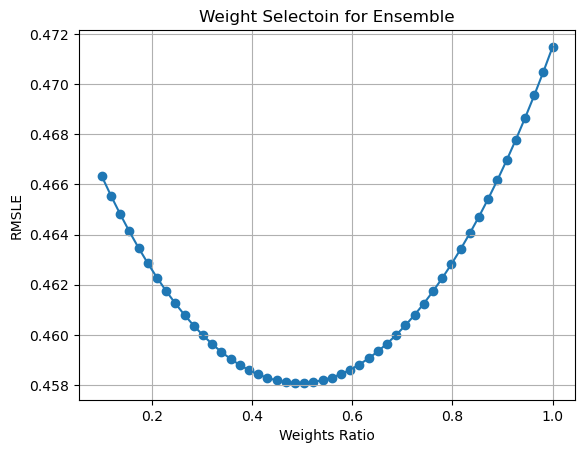

In [24]:
plt.plot(weights, scores)
plt.scatter(weights, scores)
plt.xlabel("Weights Ratio")
plt.ylabel("RMSLE")
plt.title("Weight Selectoin for Ensemble")
plt.grid()
plt.show()


Summary - As we can see from the weights (vs) RMSLE score graph, weight ratio of ~0.5 gives lowest RMSLE, We can use these weights for predictions

In [25]:
# Dataframe containing weights vs scores
df_ens = pd.DataFrame({'weights': weights, 'scores': scores})
df_ens.head(5)

,weights,scores
0,0.100000,0.466332
1,0.118367,0.465555
2,0.136735,0.464820
3,0.155102,0.464127
4,0.173469,0.463474


In [26]:
w = df_ens.weights[df_ens.scores == min(df_ens.scores)].values[0]
preds = (w*preds_ridge) + (1-w)*preds_lgbm
print("Test RMSLE of Ensemble = ", rmsle_score(np.expm1(y_test), preds))

Test RMSLE of Ensemble =  0.4580865840816271



Summary - Ensembling of LGBM (0.47) and Ridge (0.47) gives RMSLE of 0.458 which is lower than individual models. So, our Ensembling was a success here.